## Do not import any other library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from checkers.checker import check_dtmf
import pandas as pd

In [2]:
def read_and_plot(filename):
    data, sr = librosa.load(filename, sr=8000)
    librosa.display.waveplot(data, sr)
    return data, sr 

## 0. Read Sample File

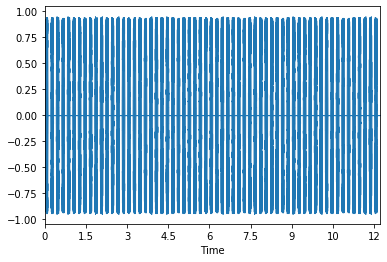

In [3]:
data, sr = read_and_plot('sample.wav')


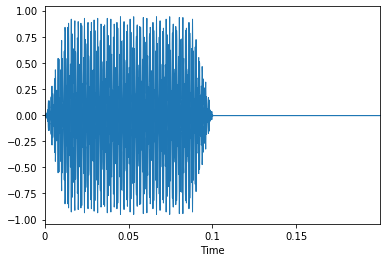

In [4]:
librosa.display.waveplot(data[0:1600], sr)

### 1. Implement DFT (You can't use built-in DFT)

In [5]:
#'https://www.youtube.com/watch?v=nl9TZanwbBk'
#The exponential matrix idea is from this tutorial
def dft(x):
    N = len(x)#Take N value
    n = np.arange(N)#Create matrix like [0,1,2,3,4]
    k = n.reshape((N, 1))#transpoese the above matrix
    expArr = np.exp(-2j * np.pi * k * n / N)#Create matrx contains exponantials
    return expArr@x #make the matrix multiplicaiton

In [6]:
np.random.seed(1773)
test = np.random.rand(1000)
check_dtmf(dft(test))

TESTING DFT
PASSED


## 2. Split sound into intervals for each digit

In [7]:
index=librosa.effects.split(data, top_db=10, frame_length=200, hop_length=50)
print(len(index))

61


## 3. Create DTMF Conversion Table

In [8]:
def ret_ch(a,b):
    #print(a,b)
    if a<=697 and b<=1209:
        return '1'
    elif a<=697 and (b>1209 and b<=1336):
         return '2'
    elif a<=697 and (b>1336 and b<=1447):
        return '3'
    elif (a>697 and a<=770) and (b<=1209):
        return '4'
    elif (a>697 and a<=770) and (b>1209 and b<=1336):
        return '5'
    elif (a>697 and a<=770) and (b>1336 and b<=1447):
        return '6'
    elif (a>770 and a<=852) and  b<=1209 :
        return '7'
    elif (a>770 and a<=852) and  (b>1209 and b<=1336) :
        return '8'
    elif (a>770 and a<=852) and  (b>1336 and b<=1447) :
        return '9'
    elif (a>852 and a<=941) and  b<=1209 :
        return '*'
    elif (a>852 and a<=941) and  (b>1209 and b<=1336) :
        return '0'
    elif (a>852 and a<=941) and  (b>1336 and b<=1447) :
        return '#'
    

## 4. Decode DTMF using *your DFT*

In [9]:
FourierTransformOfData =dft(data[index[10][0]:index[10][1]])

In [13]:
len(FourierTransformOfData.shape)

1

In [14]:
#transform it to scalar from complex number
for i in range(len(FourierTransformOfData)):
    FourierTransformOfData[i] = int(np.absolute(FourierTransformOfData[i]))

C:\Users\yetis\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


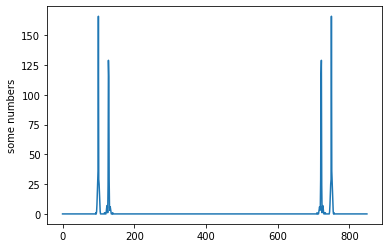

In [15]:
#in order to see the correct form
plt.plot(FourierTransformOfData)
plt.ylabel('some numbers')
plt.show()

In [16]:
#filter thee signal
#and took the left signals that are less than n/2
#in this case 0 to 400
size=len(FourierTransformOfData)
LowerBound = 20 * np.average(FourierTransformOfData[0:size//2])

In [17]:
FilteredFrequencies = []
for i in range(size//2):
    if (FourierTransformOfData[i] > LowerBound):
        FilteredFrequencies.append(i)
 

In [14]:
FilteredFrequencies=np.array(FilteredFrequencies)

In [18]:
FilteredFrequencies

[99, 100, 128, 129]

In [15]:
factor=9.2
FilteredFrequencies=FilteredFrequencies*factor

In [16]:
#example try
ret_ch((FilteredFrequencies[0]+FilteredFrequencies[1])/2,(FilteredFrequencies[-1]+FilteredFrequencies[-2])/2)

'*'

In [17]:
#splits the given wav file
#according to its muteness
def read_split(name):
    data, sr = librosa.load(name, sr=8000)
    index=librosa.effects.split(data, top_db=10, frame_length=200, hop_length=50)
    return data,index    

In [18]:
#this function takes the factor and data
#applys foruer transform
#filters the signal
#and make predictions according to DTNF table
def made_pred(_data,factor=9.2):
    FourierTransformOfData =dft(_data)
    for i in range(len(FourierTransformOfData)):
        FourierTransformOfData[i] = int(np.absolute(FourierTransformOfData[i]))
    size=len(FourierTransformOfData)
    LowerBound = 20 * np.average(FourierTransformOfData[0:size//2])
    FilteredFrequencies = []
    for i in range(size//2):
        if (FourierTransformOfData[i] > LowerBound):
            FilteredFrequencies.append(i)
    FilteredFrequencies=np.array(FilteredFrequencies)
    
    FilteredFrequencies=FilteredFrequencies*factor
    return ret_ch((FilteredFrequencies[0]+FilteredFrequencies[1])/2,(FilteredFrequencies[-1]+FilteredFrequencies[-2])/2)
    
       

In [19]:
#test prediction for the sample.wav file
made_pred(data[index[2][0]:index[2][1]])

'5'

## 5. Create Predictions

### Fors sample.csv. In this case My program gives 2 file csv file 1 is for sample input and the other one is for the 1-5 wav files.

In [20]:
with open('samplePred.csv','w') as file:
    file.write("filename,decoded,length")
    file.write('\n')
    fname="sample.wav"
    file.write(fname) 
    file.write(",") 
    data,index=read_split(fname)
    s=len(index)
    print("Decoding the sample file")
    for i in range(s):
            pred=made_pred(data[index[i][0]:index[i][1]])
            file.write(pred)
        
    file.write(",")
    file.write(str(s))
    file.write("\n")
   
    

print("done...")

Decoding the sample file
done...


# Actual predictions

In [21]:
with open('q2Pred.csv','w') as file:
    file.write("filename,decoded,length")
    file.write('\n')
    for i in range (1,6):
        fname=str(i)+".wav"
        file.write(fname) 
        file.write(",") 
        data,index=read_split(fname)
        
        s=len(index)
        print("Decoding the file",fname)
        for i in range(s):
            pred=made_pred(data[index[i][0]:index[i][1]])
            file.write(pred)
        
        file.write(",")
        file.write(str(s))
        file.write("\n")
   
    

print("done...")

Decoding the file 1.wav
Decoding the file 2.wav
Decoding the file 3.wav
Decoding the file 4.wav
Decoding the file 5.wav
done...


## 6. Comment

### DTMF means Dual Tone Multiple Freq, the other meaning is Touch Tone. By this technique we can send information with radio or phone. Here From my researches I optained that there is low and high freq's and the type of this freqs are sinusodials. So when we convert them into freq domain I encountered with 4 BARs(2 BAR means 1 sinusodial signal in this case we have 2 sinusodials so 4 BARs is what must be) . And I used the lower 2 bars in order to decode the signal. After that I filetered the signal and I multiplıed it with some value($factor$) in order to get the bounderies for the specific signal.
